# Plotting 2

In [1]:
import geopandas as gpd
import rioxarray
import xarray as xr
import xproj

import xvec

In [2]:
sentinel_2 = rioxarray.open_rasterio('svalbard.tiff')
sentinel_2

<xarray.DataArray (band: 11, y: 456, x: 625)> Size: 13MB
[3135000 values with dtype=float32]
Coordinates:
  * band         (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 5kB 11.66 11.66 11.66 11.66 ... 12.59 12.59 12.59
  * y            (y) float64 4kB 78.94 78.94 78.94 78.94 ... 78.81 78.81 78.81
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               sentinel

In [3]:
glaciers_df = gpd.read_file("https://github.com/loreabad6/post/raw/refs/heads/main/inst/extdata/svalbard.gpkg").to_crs(sentinel_2.rio.crs)
glaciers = (
    glaciers_df.set_index(["year", "name"])
    .to_xarray()
    .proj.assign_crs(spatial_ref=glaciers_df.crs)  # use xproj to store the CRS information
)

In [4]:
zonal = sentinel_2.xvec.zonal_stats(glaciers.geometry, 'x', "y", stats=['mean', 'std'])

In [5]:
zonal

<xarray.Dataset> Size: 2kB
Dimensions:           (year: 3, name: 5, zonal_statistics: 2, band: 11)
Coordinates:
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * band              (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
    spatial_ref       int64 8B 0
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
Data variables:
    statistics        (year, name, zonal_statistics, band) float32 1kB 2.52e+...

In [6]:
merged = xr.merge([glaciers, zonal])
merged

<xarray.Dataset> Size: 2kB
Dimensions:           (year: 3, name: 5, zonal_statistics: 2, band: 11)
Coordinates:
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * spatial_ref       int64 8B 0
  * band              (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
Data variables:
    length            (year, name) float64 120B 5.808e+03 ... 1.819e+03
    fwidth            (year, name) float64 120B 1.254e+03 1.216e+03 ... 202.6
    geometry          (year, name) object 120B POLYGON ((11.849495608926878 7...
    statistics        (year, name, zonal_statistics, band) float32 1kB 2.52e+...
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:4326)

Assign summary geometry.

In [7]:
merged = merged.xvec.summarize_geometry("name", "geometry", "concave_hull", ratio=.3)
merged

<xarray.Dataset> Size: 2kB
Dimensions:           (year: 3, name: 5, zonal_statistics: 2, band: 11)
Coordinates:
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * spatial_ref       int64 8B 0
  * band              (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
  * summary_geometry  (name) object 40B POLYGON ((11.693673482669782 78.89082...
Data variables:
    length            (year, name) float64 120B 5.808e+03 ... 1.819e+03
    fwidth            (year, name) float64 120B 1.254e+03 1.216e+03 ... 202.6
    geometry          (year, name) object 120B POLYGON ((11.849495608926878 7...
    statistics        (year, name, zonal_statistics, band) float32 1kB 2.52e+...
Indexes:
    spatial_ref       CRSIndex (crs=EPSG:4326)
    summary_geometry  GeometryIndex (crs=EPSG:4326)

Single statistics, single year, across bansentinel_2 on variable geom. (Dataset)

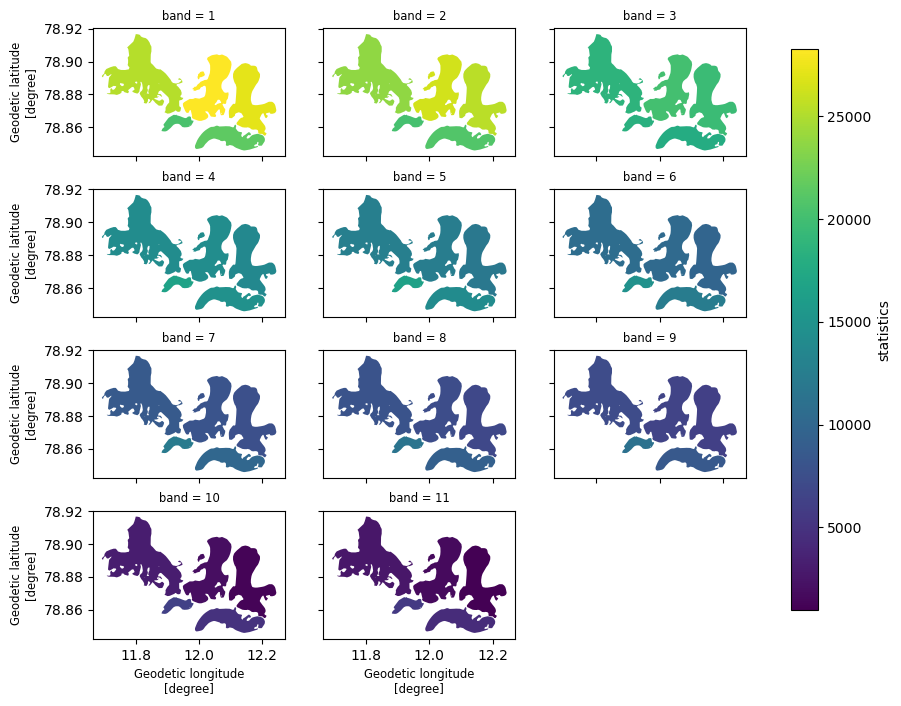

In [8]:
f, ax = merged.sel(zonal_statistics='mean', year=1936).xvec.plot(geometry="geometry", col="band", hue="statistics", col_wrap=3)

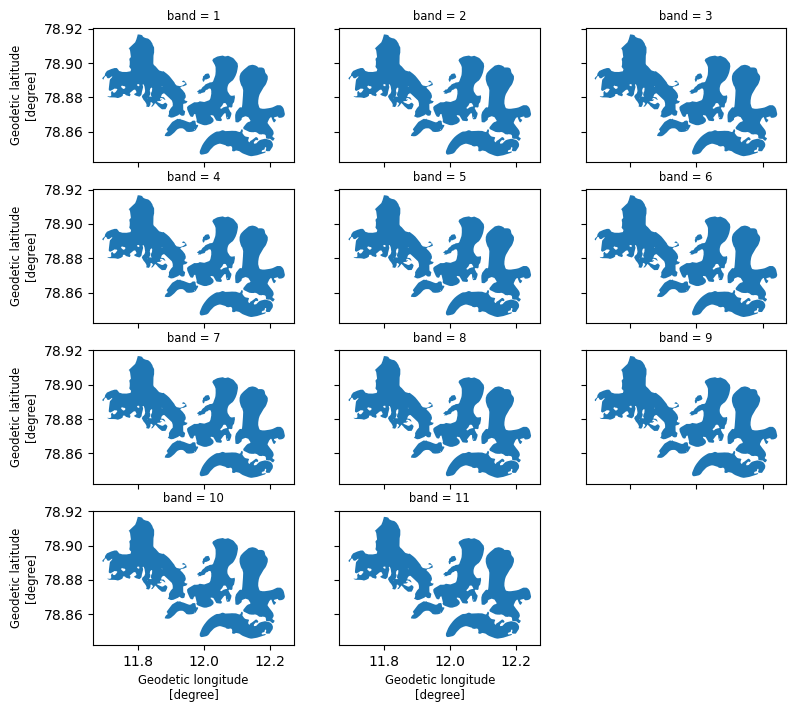

In [9]:
f, ax = merged.sel(zonal_statistics='mean', year=1936).xvec.plot(geometry="geometry", col="band", col_wrap=3)

Single statistics, single year, across bansentinel_2 on coordinate geom. (Dataset)

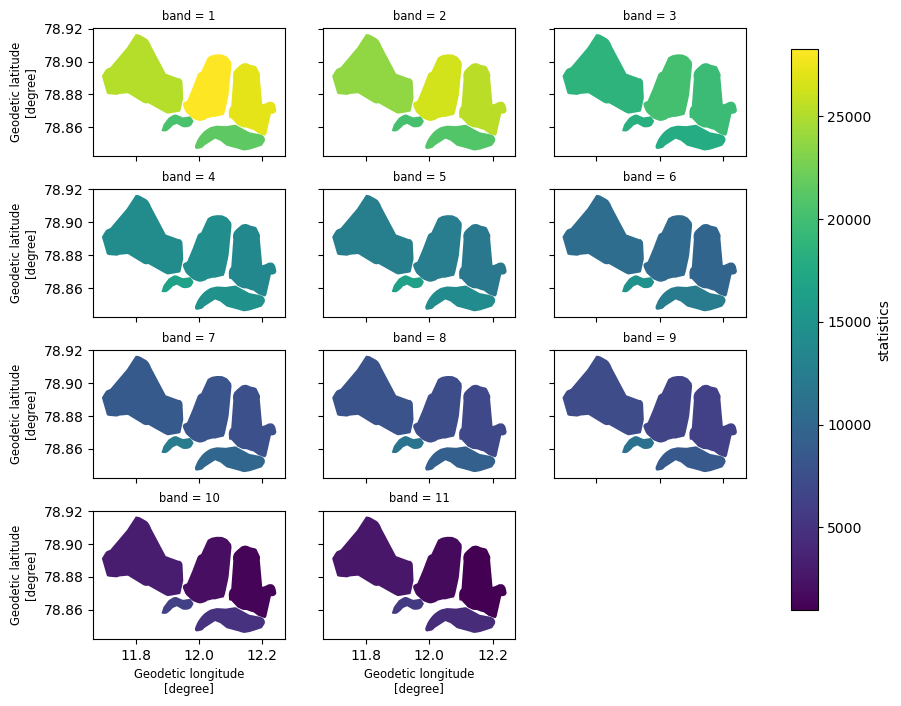

In [10]:
f, ax = merged.sel(zonal_statistics='mean', year=1936).xvec.plot(geometry="summary_geometry", col="band", hue="statistics", col_wrap=3)

In [11]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [12]:
merged['summary_geometry'].drop_vars('summary_geometry').xvec.to_geodataframe()

,spatial_ref,summary_geometry
name,,
Austre Brøggerbreen,0,"POLYGON ((11.69367 78.89083, 11.6932 78.89118,..."
Austre Lovenbreen,0,"POLYGON ((12.10821 78.88965, 12.10737 78.89055..."
Edithbreen,0,"POLYGON ((11.98817 78.84727, 11.98726 78.84772..."
Midtre Lovenbreen,0,"POLYGON ((11.94977 78.87285, 11.94894 78.8742,..."
Steenbreen,0,"POLYGON ((11.88209 78.85762, 11.88164 78.85789..."


Single statistics, grid of band and year showed on summary geometry. (DataArray)

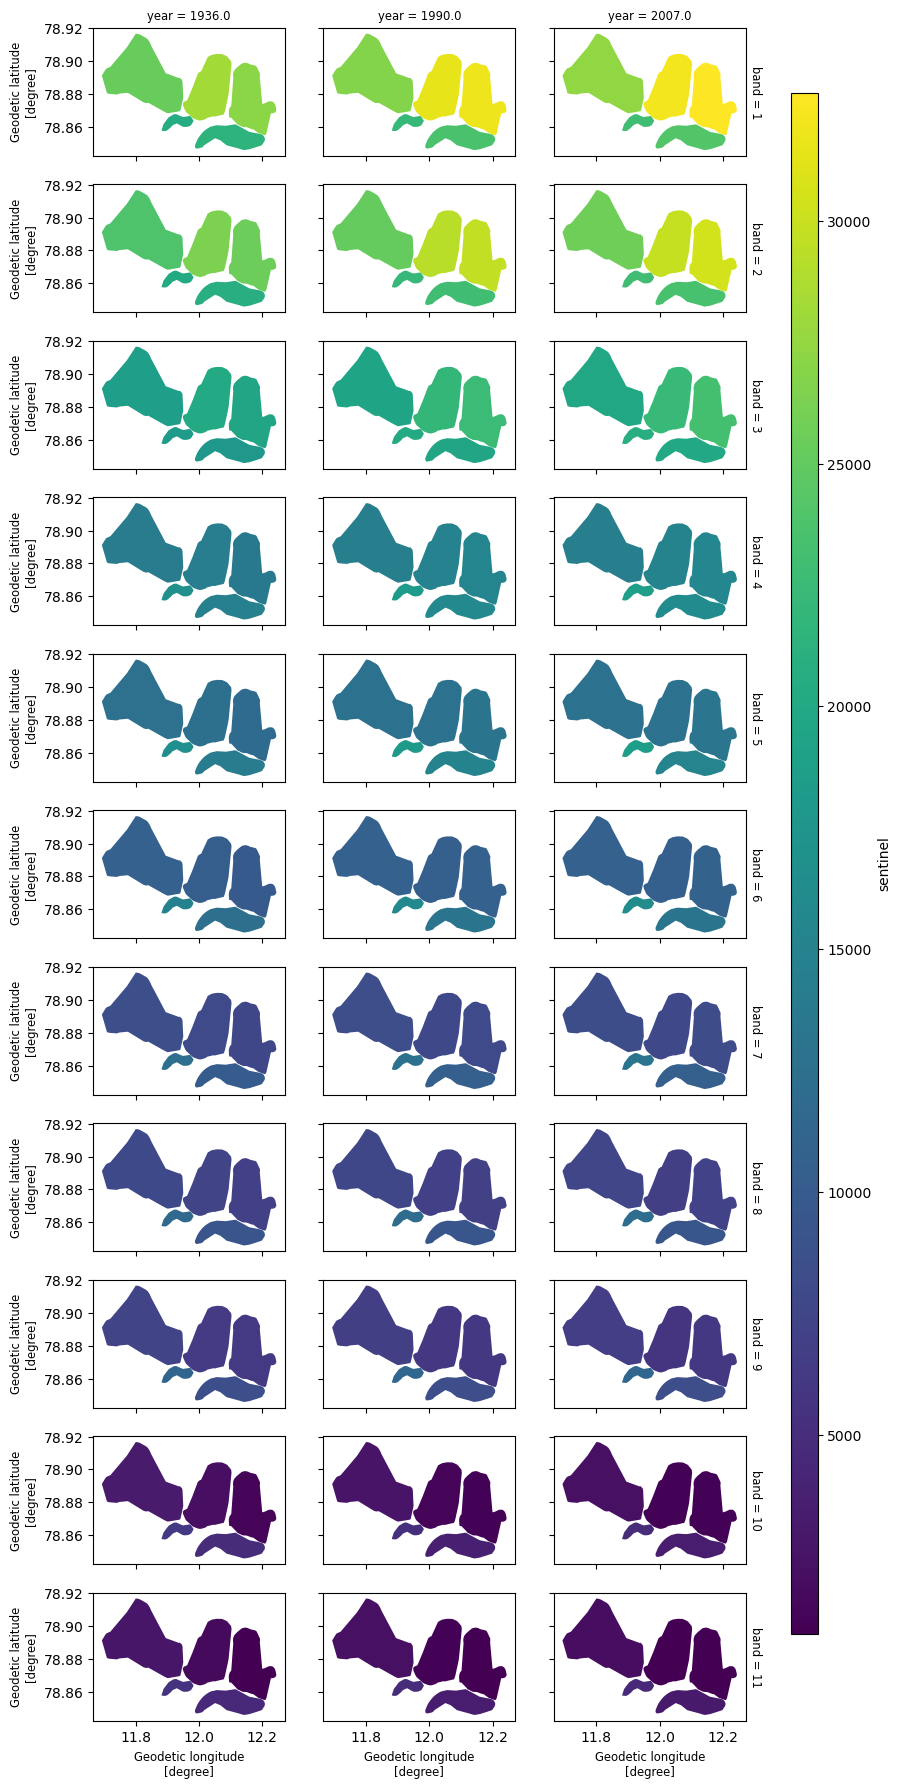

In [13]:
f, ax = merged.sel(zonal_statistics='mean').statistics.xvec.plot(row="band", col="year")

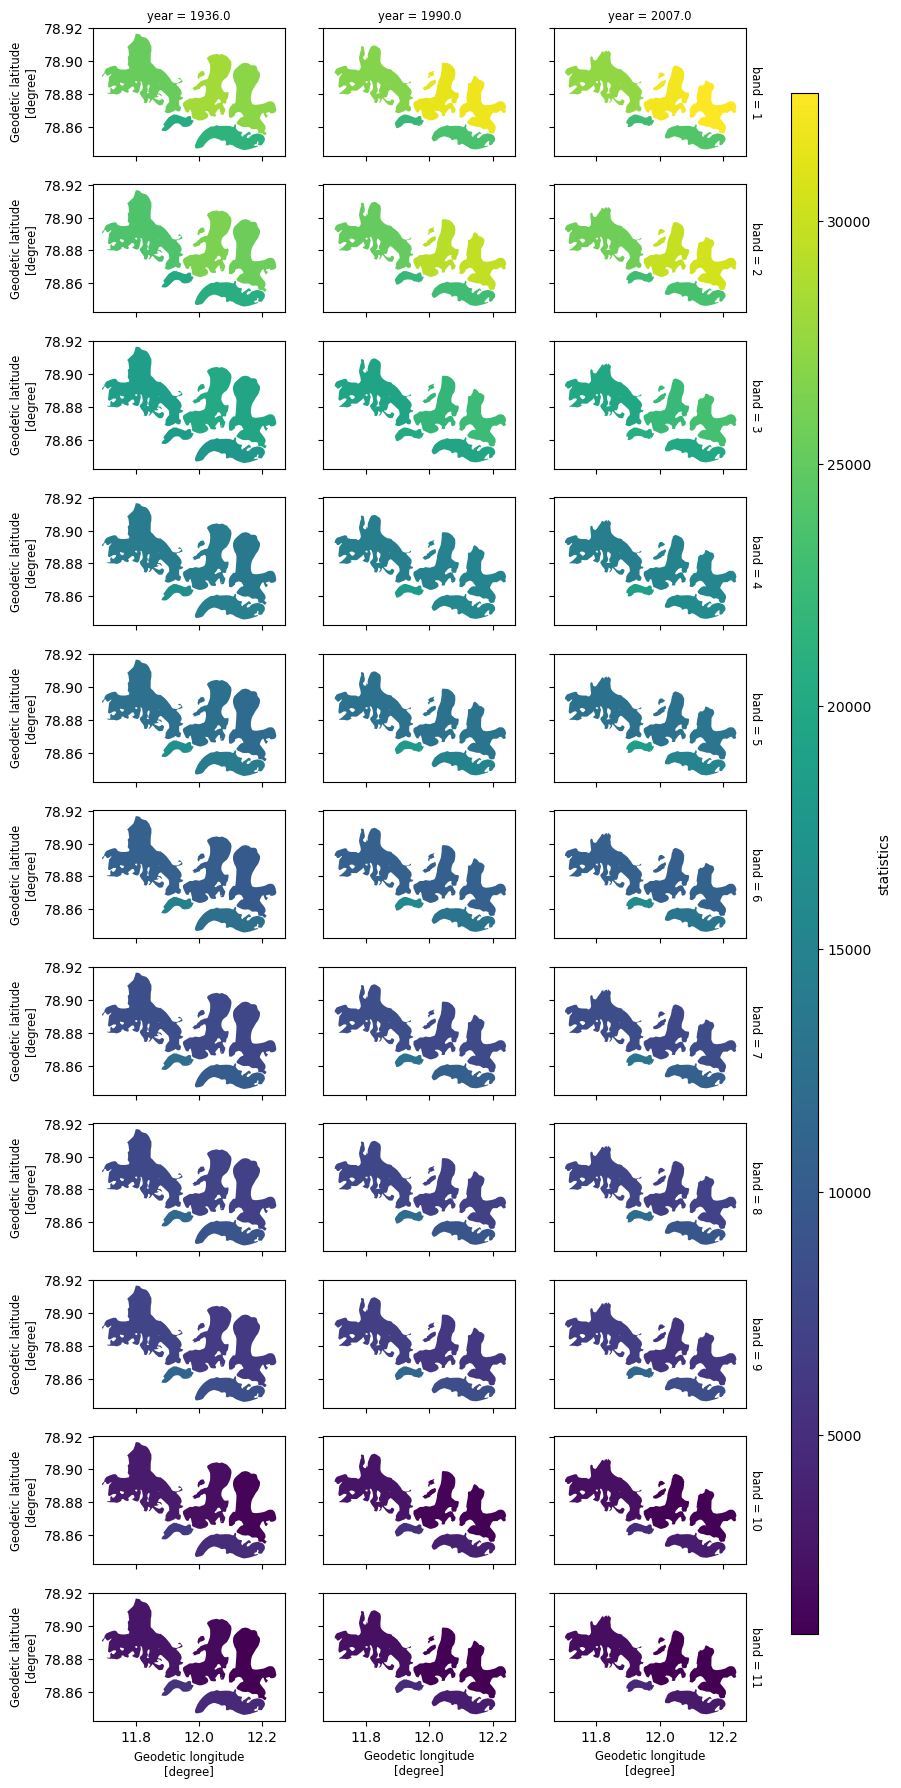

In [14]:
f, ax = merged.sel(zonal_statistics='mean').xvec.plot(geometry="geometry", row="band", col="year", hue="statistics")

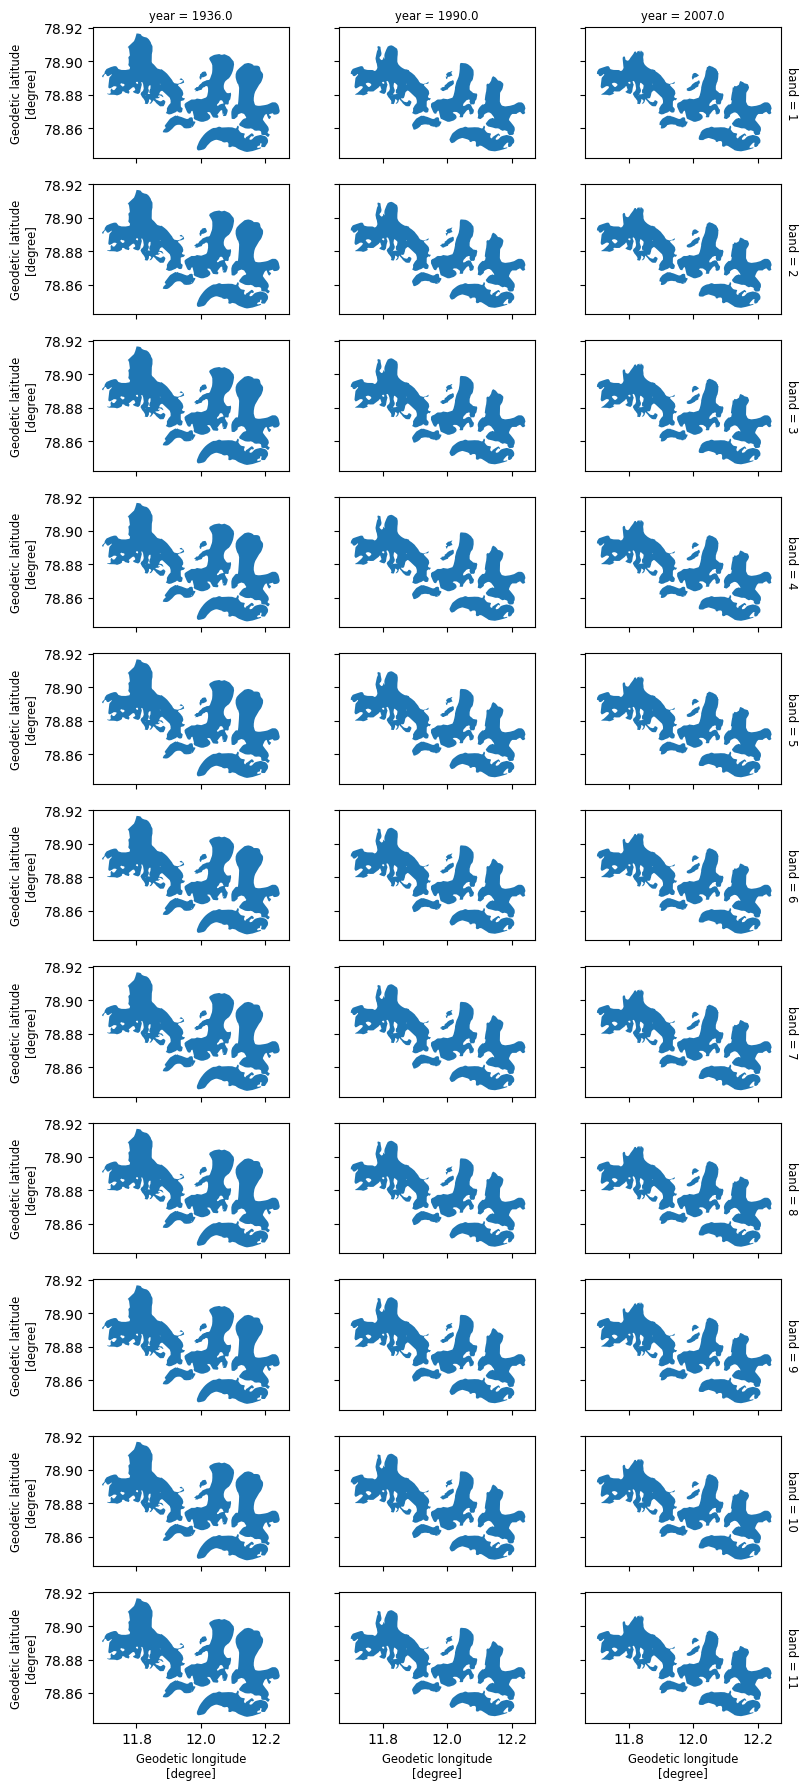

In [15]:
f, ax = merged.sel(zonal_statistics='mean').xvec.plot(geometry="geometry", row="band", col="year")

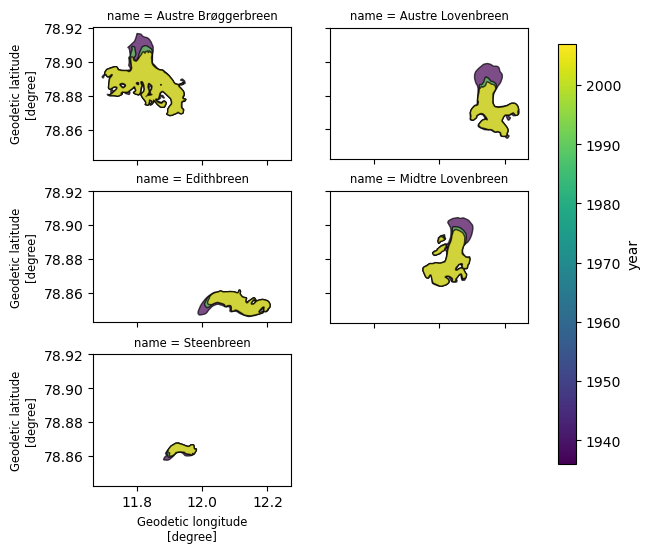

In [21]:
f, ax = merged.geometry.xvec.plot(col='name', hue='year', col_wrap=2, linewidth=1, alpha=.7, edgecolor='k')